In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm

**Load images into numpy array**

In [2]:
def readImages_hdf5(filename):
    '''Reads hdf5 file.
       Parameter
       ---------
       filename : the name of the hdf5 file
    '''
    file = h5py.File(filename + '.h5', "r+") #open the hdf5 file.
    
    hdf5_images = np.array(file["/images"]).astype("uint8") #read the images as np array
    hdf5_labels = np.array(file["/meta"]).astype("uint8") #read the images as np array
    
    return hdf5_images, hdf5_labels

In [3]:
images,labels = readImages_hdf5('mnist')
images = images.astype('float32')
labels = labels.astype('int32')

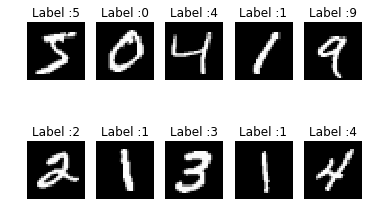

In [4]:
for sample in range(10):
    plt.subplot(2,5, sample+1)
    plt.imshow(images[sample], cmap='gray')
    plt.title("Label :" + str(labels[sample]))
    plt.axis('off')

plt.show()

**Helper functions to convert data to features of specific type**

In [5]:
def _int64_feature(value):
    #pass the tf.train.Int64List into tf.train.Feature as the data type. The given value must be in list format.
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    #pass the tf.train.BytesList into tf.train.Feature as the data type. The given value must be in list format.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    #pass the tf.train.Floatlist into tf.train.Feature as the data type. The given value must be in list format.
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [6]:
images[0].shape

(28, 28)

**Write into a TFRecords file**

In [7]:
filename = 'mnist.tfrecords'

writer = tf.python_io.TFRecordWriter(filename)

for idx in tqdm(range(images.shape[0])):
    
    im  = images[idx]
    lbl = labels[idx]
    
    feature = {
        'train/image': _bytes_feature(tf.compat.as_bytes(im.tostring())),
        'train/label': _int64_feature(lbl)
    }
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    writer.write(example.SerializeToString())

print("Write completed !")
writer.close()

100%|██████████| 60000/60000 [00:02<00:00, 23312.04it/s]


Write completed !


**Read from TFRecords file**

In [8]:
sess = tf.InteractiveSession()

feature = {
    'train/image': tf.FixedLenFeature([], tf.string),
    'train/label': tf.FixedLenFeature([], tf.int64)
}

filename_queue = tf.train.string_input_producer([filename])

reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)

features = tf.parse_single_example(serialized_example, features=feature)

image = tf.decode_raw(features['train/image'], tf.float32)
label = tf.cast(features['train/label'], tf.int32)

image = tf.reshape(image, [28,28])


images, labels = tf.train.shuffle_batch([image, label], batch_size=1, capacity=200, num_threads=1, min_after_dequeue=10)

In [9]:
#local variables have to be set for the queue
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)

#to run the FIFO queue
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [ ]:
for idx in tqdm(range(10)):
    
    img,lbl = sess.run([images,labels])
    img = img.astype(np.uint8)
    
    plt.subplot(2,5, idx+1)
    plt.imshow(img[0])
    plt.title(lbl[idx])
    plt.axis('off')
    